### Imports

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
import numpy as np
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('Data/datasheets_cleaned/2021_09_09.csv')

# Convert to GeoDataFrame and project to UTM
gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['Longitude'], data['Latitude']),
    crs="EPSG:4326"  # WGS84
)
gdf = gdf.to_crs(epsg=32632)  # Convert to UTM Zone 32V (adjust zone if needed)
gdf['UTM_X'] = gdf.geometry.x
gdf['UTM_Y'] = gdf.geometry.y

print (gdf.head())

       KM   Latitude  Longitude  RX_HorizontalWearConsumption  \
0  335845  60.733325   7.121283                         -2.57   
1  335850  60.733354   7.121352                         -1.69   
2  335855  60.733383   7.121422                         -1.70   
3  335860  60.733414   7.121489                         -1.72   
4  335865  60.733445   7.121554                          0.09   

   LX_HorizontalWearConsumption  RX_VerticalWear  LX_VerticalWear  \
0                         -1.50            -1.01             0.84   
1                         -1.77            -1.01             2.82   
2                         -1.55            -1.01             2.79   
3                         -0.73            -1.01             2.56   
4                          0.00            -0.72            -0.82   

                         geometry          UTM_X         UTM_Y  
0  POINT (397546.839 6734549.955)  397546.838921  6.734550e+06  
1  POINT (397550.731 6734553.094)  397550.731141  6.734553e+06  

In [2]:
def calculate_signed_curvature(points):
    """
    Calculate curvature with a sign to indicate direction (left or right).
    """
    curvatures = []
    epsilon = 1e-6  # Small value to avoid division by zero
    for i in range(1, len(points) - 1):
        p1, p2, p3 = points[i - 1], points[i], points[i + 1]
        x1, y1 = p1
        x2, y2 = p2
        x3, y3 = p3

        # Calculate determinant (area-based)
        det = (x1 * (y2 - y3) +
               x2 * (y3 - y1) +
               x3 * (y1 - y2))

        # Calculate distances between points
        a = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        b = np.sqrt((x3 - x2)**2 + (y3 - y2)**2)
        c = np.sqrt((x1 - x3)**2 + (y1 - y3)**2)
        # Add print statement in calculate_signed_curvature
        
        #print(f"Determinant (Area-Based) at Point {i}: {det}")


        if abs(det) < epsilon:
            curvatures.append(0)  # Treat as straight line
        else:
            # Calculate radius and curvature
            radius = (a * b * c) / (2 * abs(det))
            curvature = 1 / radius

            # Determine sign of curvature using cross product
            cross_product = (x2 - x1) * (y3 - y1) - (y2 - y1) * (x3 - x1)
            curvature *= np.sign(cross_product)  # Assign sign based on cross product

            curvatures.append(curvature)

    return [0] + curvatures + [0]  # Add padding for start and end

# Extract UTM coordinates as a list of tuples
original_points = list(zip(gdf['UTM_X'], gdf['UTM_Y']))

# Calculate signed curvature for the points
gdf['Signed_Curvature'] = calculate_signed_curvature(original_points)

# Inspect the resulting GeoDataFrame
print(gdf['Signed_Curvature'].nsmallest(10))


1443   -0.048065
634    -0.040721
1960   -0.039599
649    -0.039350
628    -0.038729
1474   -0.034738
726    -0.033933
3177   -0.033509
683    -0.032851
1462   -0.031953
Name: Signed_Curvature, dtype: float64


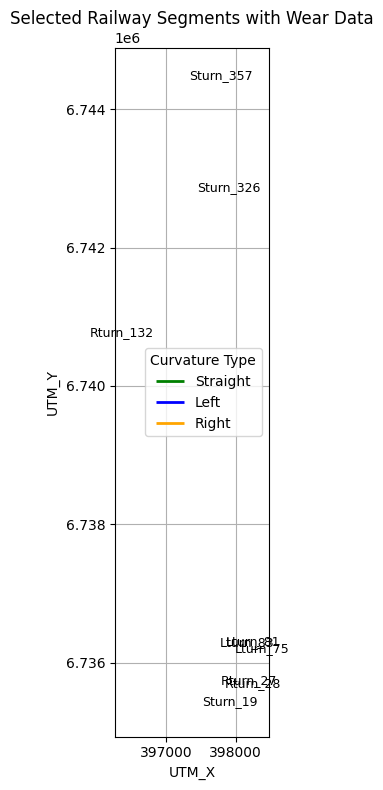

ModuleNotFoundError: No module named 'ace_tools'

In [3]:
from shapely.geometry import LineString
from scipy.spatial import distance

# Thresholds for defining significant curvature
curvature_threshold = 0.01  # Adjust based on data

# Classify curvature
def classify_curvature(curvature):
    if abs(curvature) < curvature_threshold:
        return 'Straight'
    elif curvature > 0:
        return 'Left'
    else:
        return 'Right'

gdf['Curvature_Type'] = gdf['Signed_Curvature'].apply(classify_curvature)

# Group points into segments based on curvature type
gdf['Segment_ID'] = (gdf['Curvature_Type'] != gdf['Curvature_Type'].shift()).cumsum()

# Aggregate data by segment
segments = gdf.groupby('Segment_ID').agg({
    'UTM_X': ['first', 'last'],
    'UTM_Y': ['first', 'last'],
    'Curvature_Type': 'first',
    'Signed_Curvature': ['mean', 'max', 'min'],
    'RX_HorizontalWearConsumption': 'mean',
    'LX_HorizontalWearConsumption': 'mean',
    'RX_VerticalWear': 'mean',
    'LX_VerticalWear': 'mean'
}).reset_index()

# Flatten MultiIndex columns
segments.columns = ['_'.join(col).strip('_') for col in segments.columns]

# Add segment labels
segments['Segment_Label'] = (
    segments['Curvature_Type_first'].str[0].str.upper() +
    'turn_' +
    segments.groupby('Curvature_Type_first').cumcount().add(1).astype(str)
)

# Select a few representative segments
selected_segments = pd.concat([
    segments[segments['Curvature_Type_first'] == 'Left'].nlargest(3, 'Signed_Curvature_mean'),
    segments[segments['Curvature_Type_first'] == 'Right'].nlargest(3, 'Signed_Curvature_mean'),
    segments[segments['Curvature_Type_first'] == 'Straight'].nlargest(3, 'Signed_Curvature_mean')
])

# Convert segments to GeoDataFrame
selected_segments['geometry'] = selected_segments.apply(
    lambda row: LineString([(row['UTM_X_first'], row['UTM_Y_first']), (row['UTM_X_last'], row['UTM_Y_last'])]),
    axis=1
)
segments_gdf = gpd.GeoDataFrame(selected_segments, geometry='geometry', crs="EPSG:32632")

# Plot segments
fig, ax = plt.subplots(figsize=(12, 8))

# Color code by curvature type
curvature_colors = {'Straight': 'green', 'Left': 'blue', 'Right': 'orange'}
for curvature_type, color in curvature_colors.items():
    subset = segments_gdf[segments_gdf['Curvature_Type_first'] == curvature_type]
    subset.plot(ax=ax, color=color, linewidth=2, label=curvature_type)

# Annotate segment labels
for _, segment in segments_gdf.iterrows():
    mid_x = (segment['UTM_X_first'] + segment['UTM_X_last']) / 2
    mid_y = (segment['UTM_Y_first'] + segment['UTM_Y_last']) / 2
    ax.text(mid_x, mid_y, segment['Segment_Label'], fontsize=9, ha='center')

# Add legend
ax.legend(title='Curvature Type')

# Customize plot
ax.set_title('Selected Railway Segments with Wear Data')
ax.set_xlabel('UTM_X')
ax.set_ylabel('UTM_Y')
plt.grid(True)
plt.tight_layout()
plt.show()

# Display table of selected segments
selected_columns = [
    'Segment_Label', 'Curvature_Type_first', 'Signed_Curvature_mean',
    'RX_HorizontalWearConsumption_mean', 'LX_HorizontalWearConsumption_mean',
    'RX_VerticalWear_mean', 'LX_VerticalWear_mean'
]
selected_table = segments[selected_columns]
selected_table = selected_table[selected_table['Segment_Label'].isin(selected_segments['Segment_Label'])]

import ace_tools as tools

tools.display_dataframe_to_user(name="Selected Railway Segments with Wear Data", dataframe=selected_table)


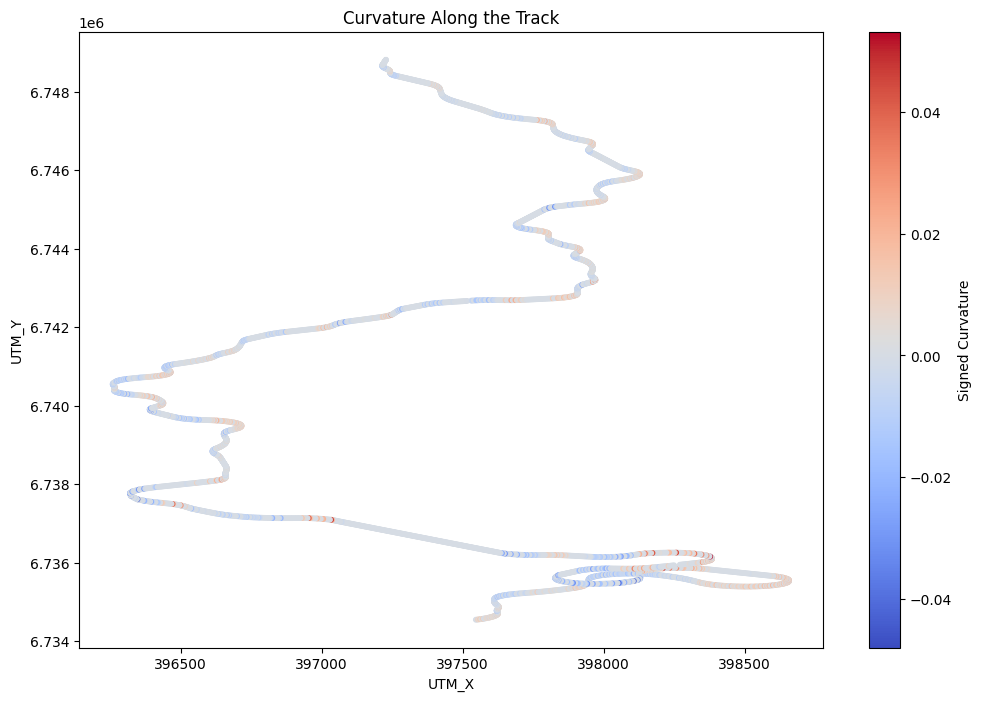

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
sc = ax.scatter(gdf['UTM_X'], gdf['UTM_Y'], c=gdf['Signed_Curvature'], cmap='coolwarm', s=10)
plt.colorbar(sc, label='Signed Curvature')
ax.set_title('Curvature Along the Track')
plt.xlabel('UTM_X')
plt.ylabel('UTM_Y')
plt.show()


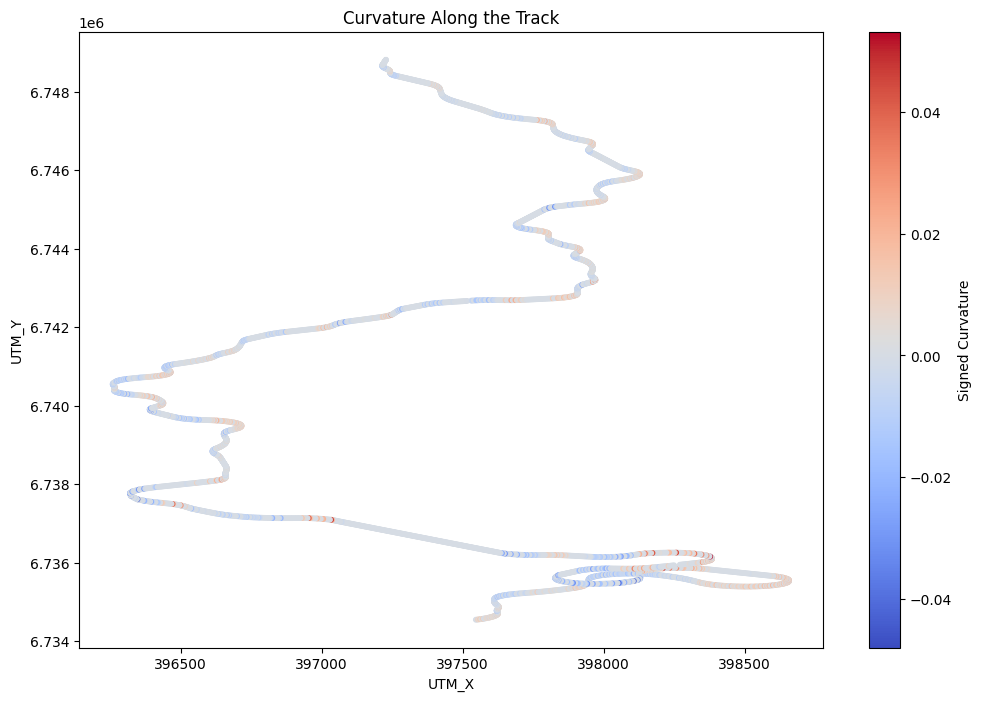

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
sc = ax.scatter(gdf['UTM_X'], gdf['UTM_Y'], c=gdf['Signed_Curvature'], cmap='coolwarm', s=10)
plt.colorbar(sc, label='Signed Curvature')
ax.set_title('Curvature Along the Track')
plt.xlabel('UTM_X')
plt.ylabel('UTM_Y')
plt.show()


In [ ]:
# Define curvature thresholds
straight_threshold = 0.0005  # Adjust this value based on your analysis

# Classify curvature
gdf['Curvature_Type'] = gdf['Signed_Curvature'].apply(
    lambda x: 'Straight' if abs(x) < straight_threshold else ('Left' if x > 0 else 'Right')
)

# Inspect classification counts
print(gdf['Curvature_Type'].value_counts())


Curvature_Type
Straight    2449
Right        784
Left         771
Name: count, dtype: int64


                RX_HorizontalWearConsumption  LX_HorizontalWearConsumption
Curvature_Type                                                            
Left                                0.544021                      0.622218
Right                               0.445740                      0.372704
Straight                            0.477591                      0.394696


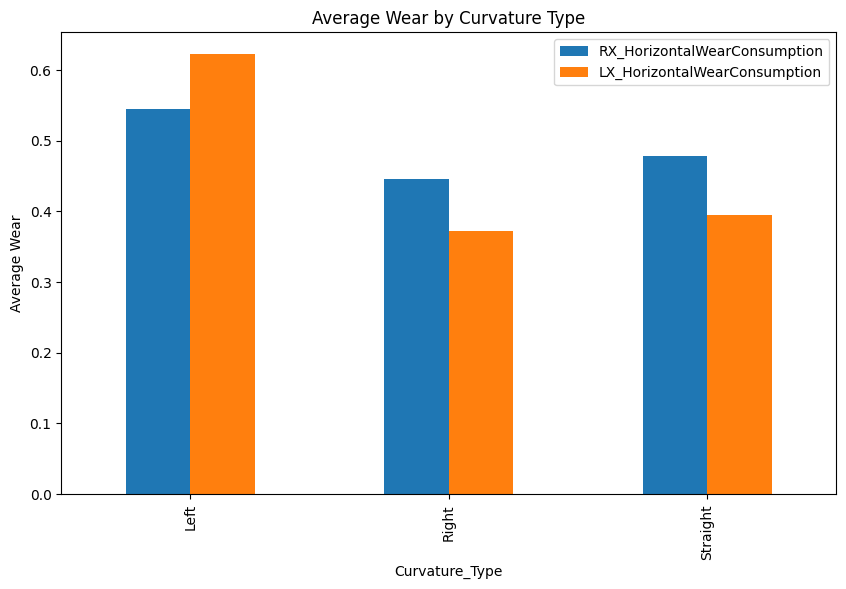

In [ ]:
# Aggregate wear by curvature type
wear_by_curvature = gdf.groupby('Curvature_Type')[['RX_HorizontalWearConsumption', 'LX_HorizontalWearConsumption']].mean()

# Inspect the results
print(wear_by_curvature)

# Plot wear by curvature type
wear_by_curvature.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Average Wear')
plt.title('Average Wear by Curvature Type')
plt.show()


In [ ]:
high_curvature = gdf[gdf['Signed_Curvature'].abs() > 0.01]
print(high_curvature[['UTM_X', 'UTM_Y', 'Signed_Curvature', 'RX_HorizontalWearConsumption']].head())


            UTM_X         UTM_Y  Signed_Curvature  \
4   397562.037998  6.734563e+06          0.013562   
7   397572.102431  6.734574e+06          0.012844   
14  397595.302124  6.734607e+06          0.010333   
28  397620.664674  6.734672e+06          0.012975   
49  397620.746203  6.734776e+06         -0.019850   

    RX_HorizontalWearConsumption  
4                           0.09  
7                          -1.71  
14                          0.39  
28                          0.29  
49                          0.24  


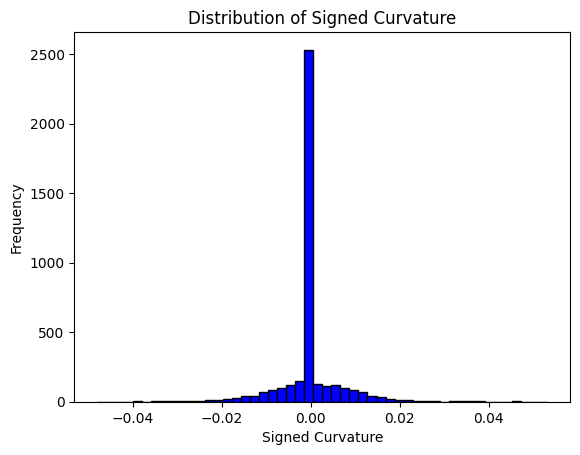

In [ ]:
plt.hist(gdf['Signed_Curvature'], bins=50, color='blue', edgecolor='black')
plt.xlabel('Signed Curvature')
plt.ylabel('Frequency')
plt.title('Distribution of Signed Curvature')
plt.show()


In [ ]:
correlation_matrix = gdf[['Signed_Curvature', 'RX_HorizontalWearConsumption', 'LX_HorizontalWearConsumption']].corr()
print(correlation_matrix)


                              Signed_Curvature  RX_HorizontalWearConsumption  \
Signed_Curvature                      1.000000                      0.020766   
RX_HorizontalWearConsumption          0.020766                      1.000000   
LX_HorizontalWearConsumption          0.057951                      0.012953   

                              LX_HorizontalWearConsumption  
Signed_Curvature                                  0.057951  
RX_HorizontalWearConsumption                      0.012953  
LX_HorizontalWearConsumption                      1.000000  


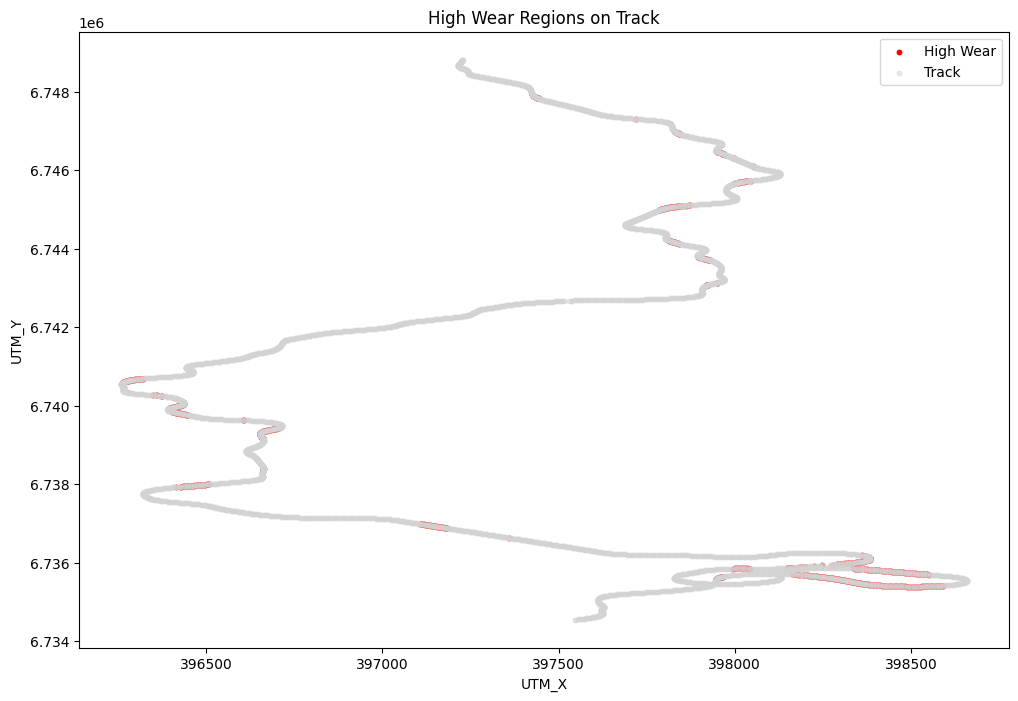

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
high_wear = gdf[gdf['RX_HorizontalWearConsumption'] > 1]  # Define an appropriate threshold
ax.scatter(high_wear['UTM_X'], high_wear['UTM_Y'], color='red', label='High Wear', s=10)
ax.scatter(gdf['UTM_X'], gdf['UTM_Y'], color='lightgray', label='Track', s=10, alpha=0.5)
ax.legend()
plt.xlabel('UTM_X')
plt.ylabel('UTM_Y')
plt.title('High Wear Regions on Track')
plt.show()


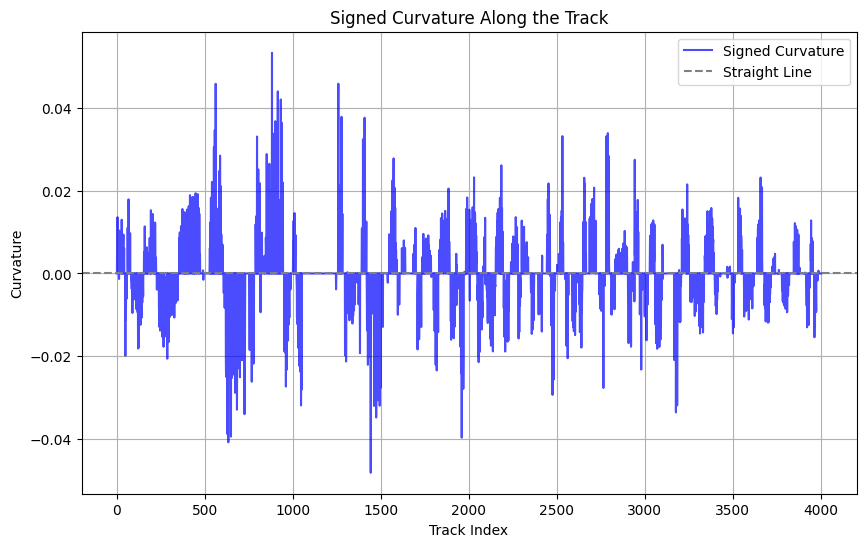

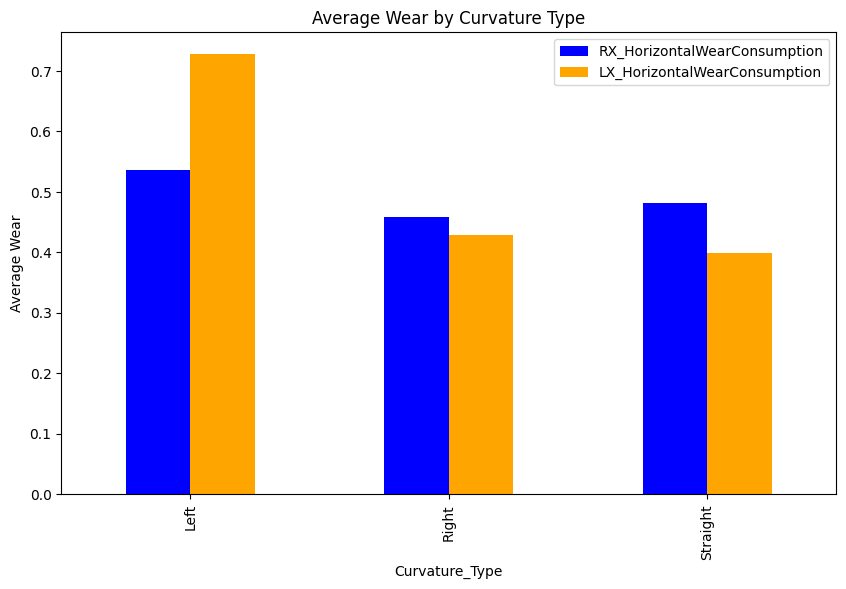

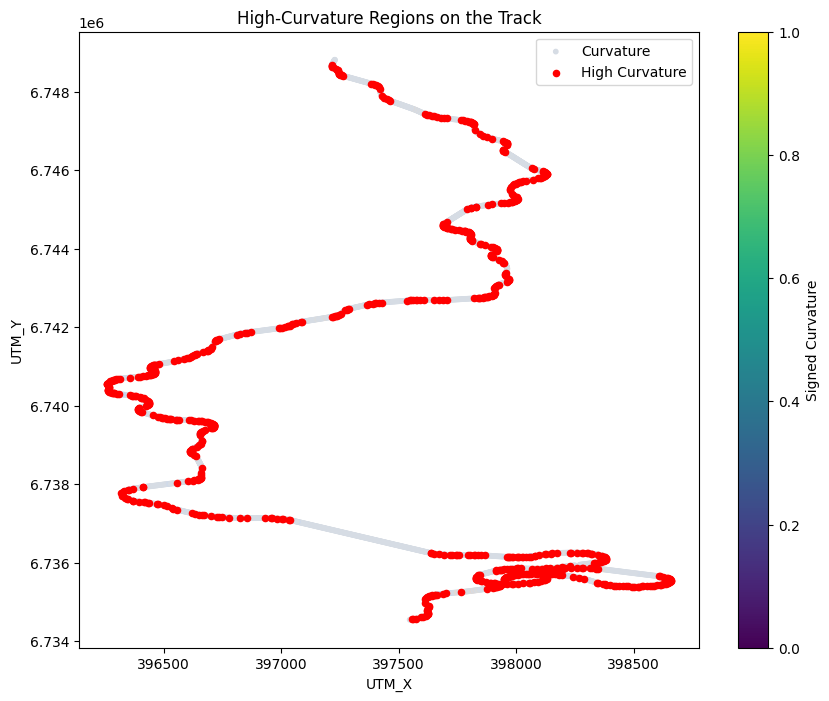

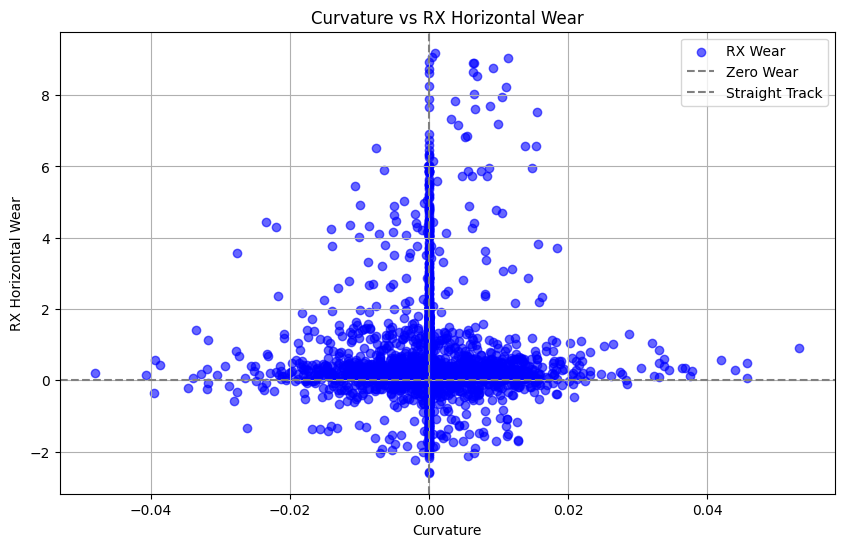

Correlation Matrix:
                               Signed_Curvature  RX_HorizontalWearConsumption  \
Signed_Curvature                      1.000000                      0.020766   
RX_HorizontalWearConsumption          0.020766                      1.000000   
LX_HorizontalWearConsumption          0.057951                      0.012953   

                              LX_HorizontalWearConsumption  
Signed_Curvature                                  0.057951  
RX_HorizontalWearConsumption                      0.012953  
LX_HorizontalWearConsumption                      1.000000  
High Wear Regions:
              UTM_X         UTM_Y  RX_HorizontalWearConsumption
236  397946.437411  6.735564e+06                          1.39
237  397946.688228  6.735569e+06                          1.57
238  397946.939044  6.735574e+06                          1.68
239  397947.189861  6.735579e+06                          1.74
240  397947.529158  6.735584e+06                          1.93
High Curvature R

,KM,Latitude,Longitude,RX_HorizontalWearConsumption,LX_HorizontalWearConsumption,RX_VerticalWear,LX_VerticalWear,geometry,UTM_X,UTM_Y,Signed_Curvature,Curvature_Type
0,335845,60.733325,7.121283,-2.57,-1.50,-1.01,0.84,POINT (397546.839 6734549.955),397546.838921,6.734550e+06,0.000000,Straight
1,335850,60.733354,7.121352,-1.69,-1.77,-1.01,2.82,POINT (397550.731 6734553.094),397550.731141,6.734553e+06,0.000000,Straight
2,335855,60.733383,7.121422,-1.70,-1.55,-1.01,2.79,POINT (397554.623 6734556.232),397554.623362,6.734556e+06,0.009617,Left
3,335860,60.733414,7.121489,-1.72,-0.73,-1.01,2.56,POINT (397558.359 6734559.553),397558.358692,6.734560e+06,0.003433,Straight
4,335865,60.733445,7.121554,0.09,0.00,-0.72,-0.82,POINT (397562.038 6734562.939),397562.037998,6.734563e+06,0.013562,Left


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('Data/datasheets_cleaned/2021_09_09.csv')

# Convert to GeoDataFrame and project to UTM
gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['Longitude'], data['Latitude']),
    crs="EPSG:4326"  # WGS84
)
gdf = gdf.to_crs(epsg=32632)  # Convert to UTM Zone 32V (adjust zone if needed)
gdf['UTM_X'] = gdf.geometry.x
gdf['UTM_Y'] = gdf.geometry.y

# Define curvature calculation function
def calculate_signed_curvature(points):
    """
    Calculate curvature with a sign to indicate direction (left or right).
    """
    curvatures = []
    epsilon = 1e-6  # Small value to avoid division by zero
    for i in range(1, len(points) - 1):
        p1, p2, p3 = points[i - 1], points[i], points[i + 1]
        x1, y1 = p1
        x2, y2 = p2
        x3, y3 = p3

        # Calculate determinant (area-based)
        det = (x1 * (y2 - y3) +
               x2 * (y3 - y1) +
               x3 * (y1 - y2))

        # Calculate distances between points
        a = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        b = np.sqrt((x3 - x2)**2 + (y3 - y2)**2)
        c = np.sqrt((x1 - x3)**2 + (y1 - y3)**2)

        if abs(det) < epsilon:
            curvatures.append(0)  # Treat as straight line
        else:
            # Calculate radius and curvature
            radius = (a * b * c) / (2 * abs(det))
            curvature = 1 / radius

            # Determine sign of curvature using cross product
            cross_product = (x2 - x1) * (y3 - y1) - (y2 - y1) * (x3 - x1)
            curvature *= np.sign(cross_product)  # Assign sign based on cross product

            curvatures.append(curvature)

    return [0] + curvatures + [0]  # Add padding for start and end

# Extract UTM coordinates as a list of tuples
original_points = list(zip(gdf['UTM_X'], gdf['UTM_Y']))

# Calculate signed curvature
gdf['Signed_Curvature'] = calculate_signed_curvature(original_points)

# Plot curvature along the track
plt.figure(figsize=(10, 6))
plt.plot(gdf.index, gdf['Signed_Curvature'], label='Signed Curvature', color='blue', alpha=0.7)
plt.axhline(0, color='gray', linestyle='--', label='Straight Line')
plt.xlabel('Track Index')
plt.ylabel('Curvature')
plt.title('Signed Curvature Along the Track')
plt.legend()
plt.grid(True)
plt.show()

# Define curvature thresholds dynamically
low_threshold = gdf['Signed_Curvature'].quantile(0.10)
high_threshold = gdf['Signed_Curvature'].quantile(0.90)

# Classify curvature
gdf['Curvature_Type'] = gdf['Signed_Curvature'].apply(
    lambda x: 'Straight' if low_threshold < x < high_threshold else ('Left' if x > high_threshold else 'Right')
)

# Plot wear vs curvature classification
wear_by_curvature = gdf.groupby('Curvature_Type')[['RX_HorizontalWearConsumption', 'LX_HorizontalWearConsumption']].mean()
wear_by_curvature.plot(kind='bar', figsize=(10, 6), color=['blue', 'orange'])
plt.ylabel('Average Wear')
plt.title('Average Wear by Curvature Type')
plt.show()

# Highlight high-curvature and high-wear regions
high_curvature = gdf[gdf['Signed_Curvature'].abs() > high_threshold]
high_wear = gdf[gdf['RX_HorizontalWearConsumption'] > 1]  # Example threshold

# Plot curvature and high-curvature regions
plt.figure(figsize=(10, 8))
plt.scatter(gdf['UTM_X'], gdf['UTM_Y'], c=gdf['Signed_Curvature'], cmap='coolwarm', s=10, label='Curvature')
plt.scatter(high_curvature['UTM_X'], high_curvature['UTM_Y'], color='red', s=20, label='High Curvature')
plt.colorbar(label='Signed Curvature')
plt.xlabel('UTM_X')
plt.ylabel('UTM_Y')
plt.title('High-Curvature Regions on the Track')
plt.legend()
plt.show()

# Plot wear vs curvature scatter
plt.figure(figsize=(10, 6))
plt.scatter(gdf['Signed_Curvature'], gdf['RX_HorizontalWearConsumption'], alpha=0.6, label='RX Wear', color='blue')
plt.axhline(0, color='gray', linestyle='--', label='Zero Wear')
plt.axvline(0, color='gray', linestyle='--', label='Straight Track')
plt.xlabel('Curvature')
plt.ylabel('RX Horizontal Wear')
plt.title('Curvature vs RX Horizontal Wear')
plt.legend()
plt.grid(True)
plt.show()

# Correlation matrix
correlation_matrix = gdf[['Signed_Curvature', 'RX_HorizontalWearConsumption', 'LX_HorizontalWearConsumption']].corr()
print("Correlation Matrix:\n", correlation_matrix)

# Inspect high-wear and high-curvature points
print("High Wear Regions:\n", high_wear[['UTM_X', 'UTM_Y', 'RX_HorizontalWearConsumption']].head())
print("High Curvature Regions:\n", high_curvature[['UTM_X', 'UTM_Y', 'Signed_Curvature']].head())


gdf.head()  


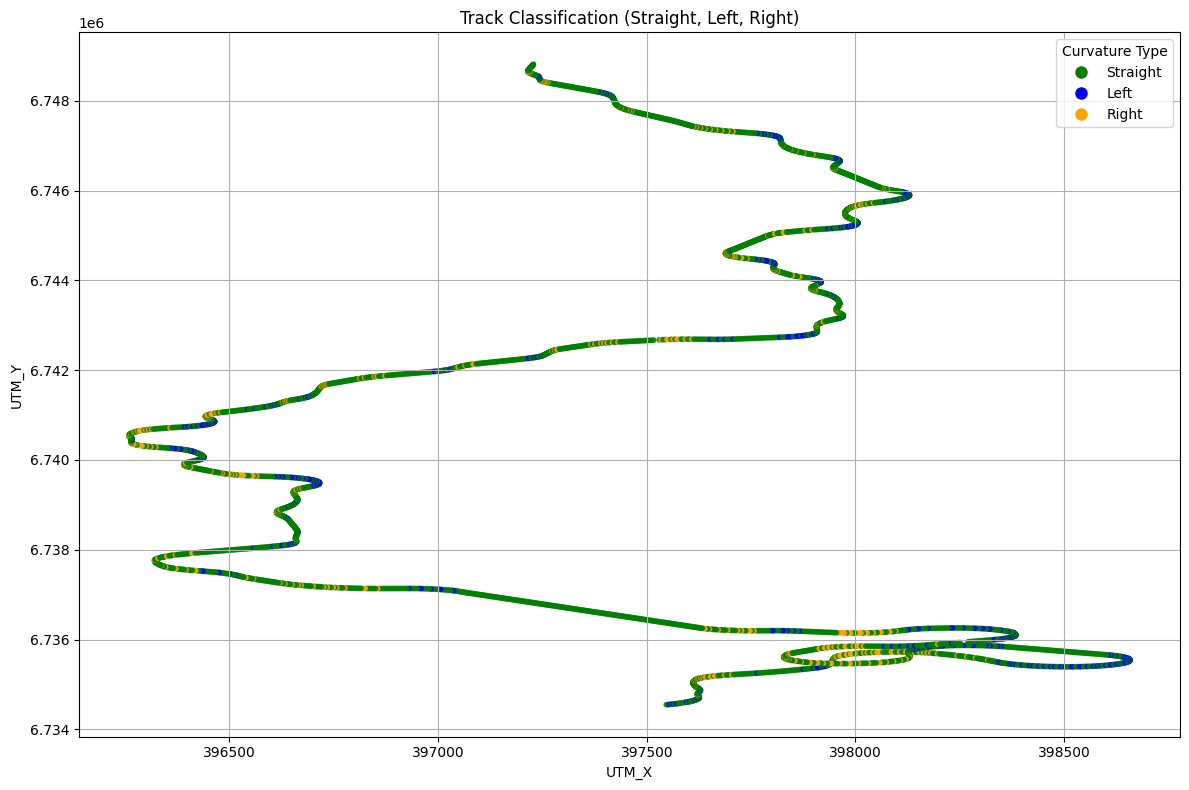

In [ ]:
# Define colors for curvature types
colors = {'Straight': 'green', 'Left': 'blue', 'Right': 'orange'}

# Plot track classification
plt.figure(figsize=(12, 8))
plt.scatter(gdf['UTM_X'], gdf['UTM_Y'], 
            c=gdf['Curvature_Type'].map(colors), 
            s=10, alpha=0.8, label='Track Classification')

# Add a legend with curvature types
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', label=key, markerfacecolor=value, markersize=10) 
                 for key, value in colors.items()]
plt.legend(handles=legend_labels, title='Curvature Type', loc='upper right')

# Customize plot
plt.xlabel('UTM_X')
plt.ylabel('UTM_Y')
plt.title('Track Classification (Straight, Left, Right)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Downsample the points
n = 5  # Downsample factor
downsampled_points = original_points[::n]

# Calculate curvature for downsampled points
curvature_downsampled = calculate_signed_curvature(downsampled_points)

# Create a new GeoDataFrame for segments
segments = pd.DataFrame({
    'Start_UTM_X': [p[0] for p in downsampled_points[:-1]],
    'Start_UTM_Y': [p[1] for p in downsampled_points[:-1]],
    'End_UTM_X': [p[0] for p in downsampled_points[1:]],
    'End_UTM_Y': [p[1] for p in downsampled_points[1:]],
    'Curvature': curvature_downsampled[:-1]
})

# Classify segments based on curvature thresholds
low_threshold = np.quantile(segments['Curvature'], 0.05)
high_threshold = np.quantile(segments['Curvature'], 0.95)

segments['Curvature_Type'] = segments['Curvature'].apply(
    lambda x: 'Straight' if low_threshold < x < high_threshold else ('Left' if x > high_threshold else 'Right')
)

# Initialize an empty DataFrame for segment wear data
segment_wear = []

# Aggregate wear data for each segment
for i, segment in segments.iterrows():
    # Filter points within the segment bounds
    segment_points = gdf[
        (gdf['UTM_X'] >= min(segment['Start_UTM_X'], segment['End_UTM_X'])) &
        (gdf['UTM_X'] <= max(segment['Start_UTM_X'], segment['End_UTM_X'])) &
        (gdf['UTM_Y'] >= min(segment['Start_UTM_Y'], segment['End_UTM_Y'])) &
        (gdf['UTM_Y'] <= max(segment['Start_UTM_Y'], segment['End_UTM_Y']))
    ]

    # Aggregate wear data for the segment
    rx_horizontal_sum = segment_points['RX_HorizontalWearConsumption'].mean()
    lx_horizontal_sum = segment_points['LX_HorizontalWearConsumption'].mean()
    rx_vertical_sum = segment_points['RX_VerticalWear'].mean()
    lx_vertical_sum = segment_points['LX_VerticalWear'].mean()

    # Append aggregated data
    segment_wear.append({
        'Segment_ID': f"{segment['Curvature_Type']}_{i+1}",
        'Curvature_Type': segment['Curvature_Type'],
        'RX_Horizontal_Sum': rx_horizontal_sum,
        'LX_Horizontal_Sum': lx_horizontal_sum,
        'RX_Vertical_Sum': rx_vertical_sum,
        'LX_Vertical_Sum': lx_vertical_sum
    })

# Create a DataFrame for wear data
segment_wear_df = pd.DataFrame(segment_wear)

# Inspect the segment table
print(segment_wear_df.head())

# Save the table for later analysis
#segment_wear_df.to_csv('railway_segments_with_wear.csv', index=False)


   Segment_ID Curvature_Type  RX_Horizontal_Sum  LX_Horizontal_Sum  \
0  Straight_1       Straight          -1.513333          -1.185000   
1  Straight_2       Straight          -0.708333          -0.653333   
2  Straight_3       Straight           0.305000           0.230000   
3  Straight_4       Straight           0.206667           0.213333   
4  Straight_5       Straight           0.278333           0.156667   

   RX_Vertical_Sum  LX_Vertical_Sum  
0        -0.393333         1.796667  
1        -0.506667         0.570000  
2        -0.658333        -1.191667  
3        -0.371667        -0.588333  
4        -0.510000        -0.386667  


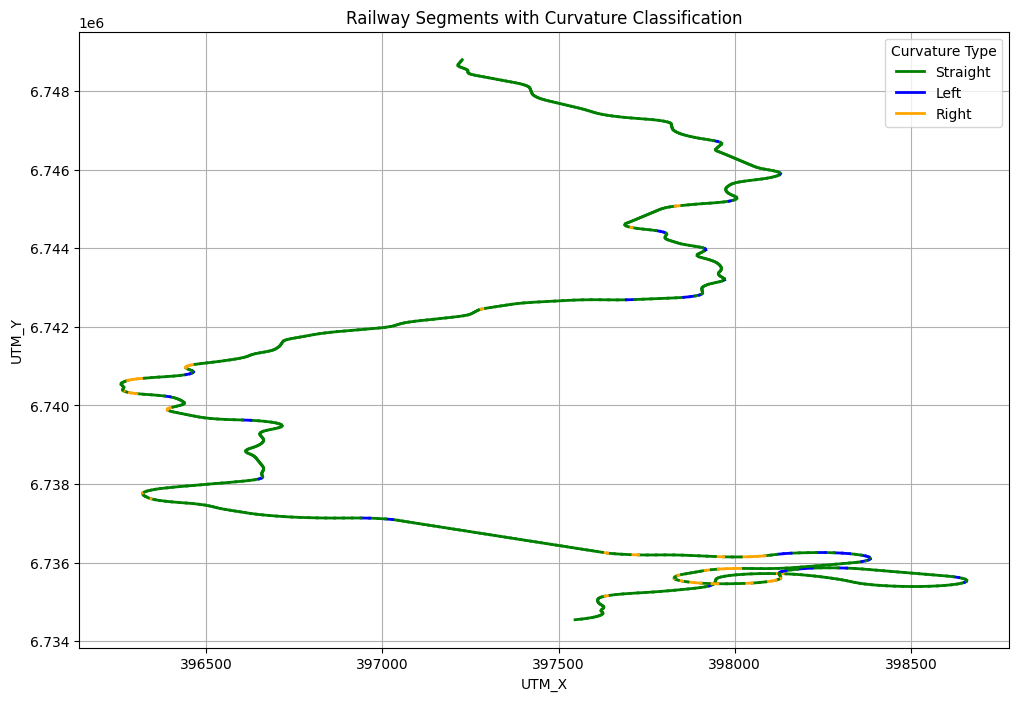

In [ ]:
import matplotlib.colors as mcolors

# Define colors for curvature types
curvature_colors = {
    'Straight': 'green',
    'Left': 'blue',
    'Right': 'orange'
}

# Add a line geometry for each segment to the GeoDataFrame
segments['geometry'] = segments.apply(
    lambda row: LineString([(row['Start_UTM_X'], row['Start_UTM_Y']), 
                            (row['End_UTM_X'], row['End_UTM_Y'])]), axis=1
)
segments_gdf = gpd.GeoDataFrame(segments, geometry='geometry', crs="EPSG:32632")

# Plot railway segments color-coded by curvature type
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each segment with its curvature type color
for _, segment in segments_gdf.iterrows():
    ax.plot(
        [segment['Start_UTM_X'], segment['End_UTM_X']],
        [segment['Start_UTM_Y'], segment['End_UTM_Y']],
        color=curvature_colors[segment['Curvature_Type']],
        linewidth=2,
        label=segment['Curvature_Type'] if segment['Curvature_Type'] not in ax.get_legend_handles_labels()[1] else ''
    )

# Add legend
legend_elements = [
    plt.Line2D([0], [0], color=color, lw=2, label=curvature)
    for curvature, color in curvature_colors.items()
]
ax.legend(handles=legend_elements, title='Curvature Type')

# Add segment labels (optional, displaying RX horizontal wear sum)
# for i, segment in segments.iterrows():
#     mid_x = (segment['Start_UTM_X'] + segment['End_UTM_X']) / 2
#     mid_y = (segment['Start_UTM_Y'] + segment['End_UTM_Y']) / 2
#     rx_wear = segment_wear[i]['RX_Horizontal_Sum']
#     ax.text(mid_x, mid_y, f"{rx_wear:.1f}", fontsize=8, ha='center')

# Customize the plot
ax.set_xlabel('UTM_X')
ax.set_ylabel('UTM_Y')
ax.set_title('Railway Segments with Curvature Classification')
ax.grid(True)

plt.show()


AttributeError: 'int' object has no attribute 'euclidean'